In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.16.1


## Import the Dataset

In [2]:
BATCH_SIZE = 64
IMG_SIZE = (128, 128)

dataset = image_dataset_from_directory(
    "/kaggle/input/weather-dataset/dataset",
    image_size=IMG_SIZE,  # Resize images to this size
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # One-hot encode the labels (suitable for classification)
    shuffle=True  # Shuffle the dataset
)

Found 6862 files belonging to 11 classes.


## Explore the data

In [3]:
for images, labels in dataset.take(1):
    print(images.shape)
    print(labels.shape)
# Número de batches
len(dataset)

(64, 128, 128, 3)
(64, 11)


108

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

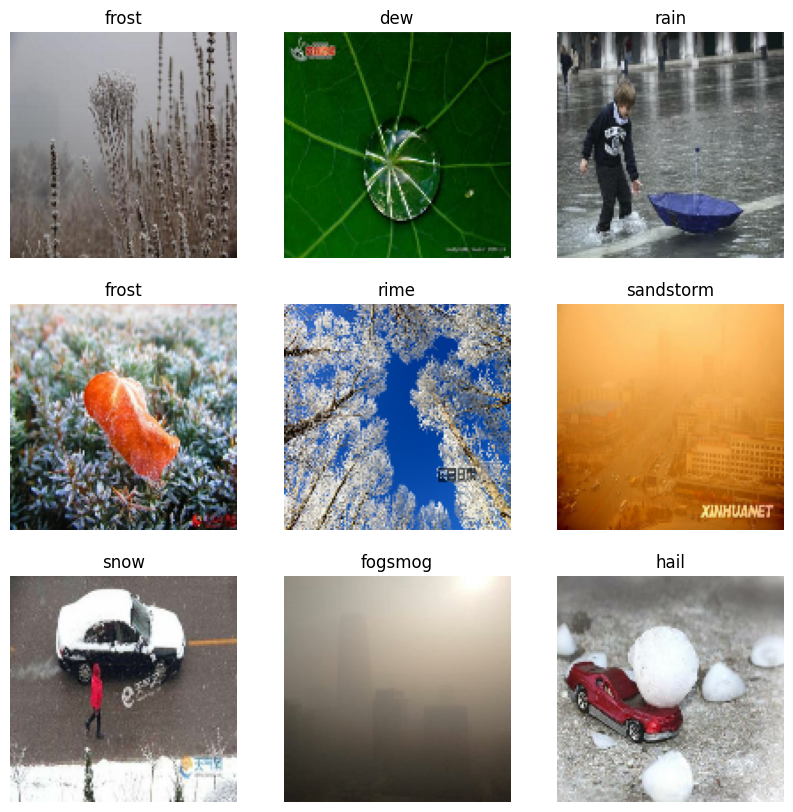

In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

image_batch, label_batch = next(iter(dataset))

def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")

plot_images(image_batch, label_batch, class_names)
plt.show()

In [5]:
image_batch[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[141.58594  , 144.58594  , 153.58594  ],
        [147.10938  , 150.10938  , 159.10938  ],
        [150.80286  , 153.80286  , 162.80286  ],
        ...,
        [165.       , 168.       , 175.       ],
        [165.55469  , 164.       , 169.44531  ],
        [158.       , 157.       , 163.       ]],

       [[142.85156  , 145.85156  , 154.85156  ],
        [149.10938  , 152.10938  , 161.10938  ],
        [152.40857  , 155.40857  , 164.40857  ],
        ...,
        [165.       , 168.       , 175.       ],
        [166.44531  , 164.89062  , 170.33594  ],
        [160.       , 159.       , 165.       ]],

       [[144.85156  , 147.85156  , 156.85156  ],
        [148.55469  , 151.55469  , 160.55469  ],
        [153.       , 156.       , 165.       ],
        ...,
        [165.       , 168.       , 175.       ],
        [166.55469  , 165.       , 170.44531  ],
        [161.85156  , 160.85156  , 166.85156  ]],

       ...,

     

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [6]:
def preprocess(image, label=None):
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to 0-1
    if label is None:
        return image  # For test set (no labels)
    return image, label

In [7]:
num_samples = tf.data.experimental.cardinality(dataset).numpy()
print(f"Total samples: {num_samples}")

# Calculate the sizes for each split
train_size = int(num_samples * 0.7)  # 70% for training
val_size = int(num_samples * 0.15)    # 15% for validation
test_size = num_samples - train_size - val_size  # Remaining 15% for testing

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

Total samples: 108


In [8]:
# Apply the preprocessing to the datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [9]:
image_batch, label_batch = next(iter(train_dataset))
image_batch[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.43553922, 0.30612746, 0.14534314],
        [0.4477941 , 0.31838235, 0.15759803],
        [0.45694605, 0.3250833 , 0.16552447],
        ...,
        [0.4513107 , 0.327046  , 0.16258521],
        [0.43995097, 0.31446078, 0.16004902],
        [0.42769608, 0.3022059 , 0.15318628]],

       [[0.44339767, 0.3139859 , 0.1532016 ],
        [0.45565256, 0.3262408 , 0.16545649],
        [0.4639907 , 0.33212796, 0.17256913],
        ...,
        [0.45613223, 0.33186755, 0.16740675],
        [0.44388786, 0.31839767, 0.16398591],
        [0.43529508, 0.3098049 , 0.16078527]],

       [[0.45247492, 0.32306316, 0.16227883],
        [0.4648131 , 0.33540136, 0.17461704],
        [0.47314644, 0.3412837 , 0.18172488],
        ...,
        [0.46138173, 0.33711705, 0.17265625],
        [0.45171568, 0.3262255 , 0.17181373],
        [0.43946078, 0.3139706 , 0.16495098]],

       ...,

       [[0.22753428, 0.13341662, 0.03663354],
        [0.23

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2)
])

cnn = tf.keras.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  
])

model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    cnn
])

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Se cambia porque está one-hot encoded
              metrics=[tf.keras.metrics.F1Score(average='weighted'),'accuracy'],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 11)             │     3,604,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,604,683 (13.75 MB)

 Trainable params: 3,604,683 (13.75 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.2500 - f1_score: 0.1937 - loss: 2.1328 - val_accuracy: 0.5654 - val_f1_score: 0.5566 - val_loss: 1.3293
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5165 - f1_score: 0.5078 - loss: 1.4200 - val_accuracy: 0.5684 - val_f1_score: 0.5734 - val_loss: 1.2736
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5444 - f1_score: 0.5378 - loss: 1.2951 - val_accuracy: 0.6543 - val_f1_score: 0.6555 - val_loss: 1.0442
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5914 - f1_score: 0.5859 - loss: 1.1768 - val_accuracy: 0.6299 - val_f1_score: 0.6425 - val_loss: 1.0647
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6095 - f1_score: 0.6059 - loss: 1.1080 - val_accuracy: 0.6514 - val_f1_score: 0.6464 - val_loss: 1.0161
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6301 - f1_score: 0.6272 - loss: 1.0488 - val_accuracy: 0.6543 - val_f1_score: 0.65

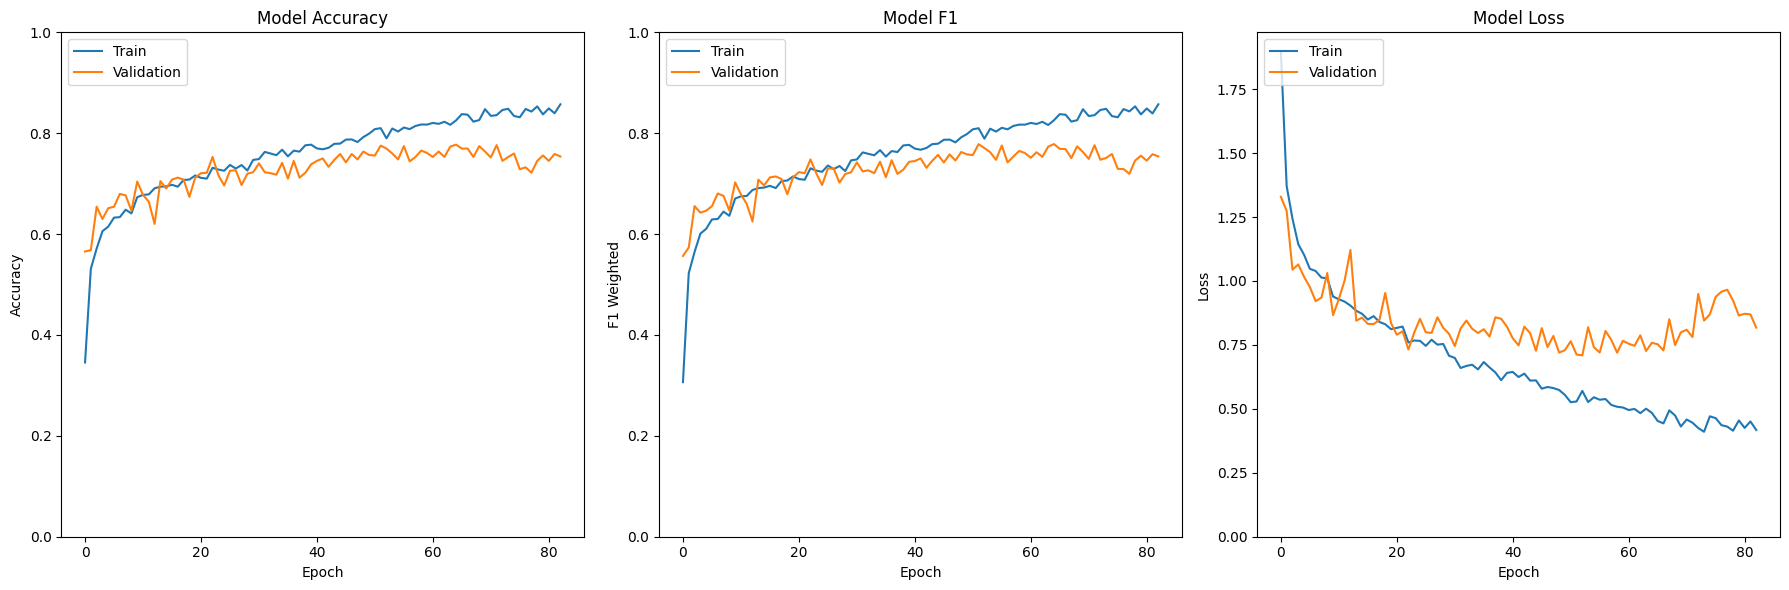

In [14]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.set_ylim([0,1])

# Plot training & validation accuracy values
ax2.plot(history.history['f1_score'])
ax2.plot(history.history['val_f1_score'])
ax2.set_title('Model F1')
ax2.set_ylabel('F1 Weighted')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.set_ylim([0,1])

# Plot training & validation loss values
ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set_title('Model Loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['Train', 'Validation'], loc='upper left')
ax3.set_ylim(bottom=0)

# Show the plots
plt.tight_layout()
plt.show()

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [15]:
val_loss, val_f1, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 by Class: {val_f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8018 - f1_score: 0.8025 - loss: 0.6393
Validation Loss: 0.7089935541152954
Validation Accuracy: 0.76953125
Validation F1 by Class: 0.7705553770065308


In [16]:
test_loss, test_f1, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 by Class: {test_f1}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.7568 - f1_score: 0.7565 - loss: 0.7973
Test Loss: 0.8625053763389587
Test Accuracy: 0.747591495513916
Test F1 by Class: 0.7492698431015015


In [17]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [18]:
images, labels = next(iter(test_dataset))
predictions = model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


In [19]:
predicted_labels_idx = np.argmax(predictions, axis=1)
labels = np.argmax(labels, axis=1)

Text(0.5, 1.0, 'Label: glaze | Prediction: glaze')

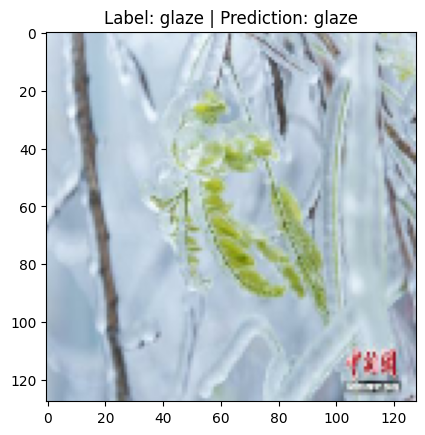

In [20]:
plt.imshow(images[0])
plt.title(f"Label: {class_names[labels[0]]} | Prediction: {class_names[predicted_labels_idx[0]]}")

Para esta actividad, tanto para el modelo LeNet como otros tipos de redes convolucionales, tuve una gran lección sobre la calidad y variabilidad de los datos. Para este notebook en particular, se escogió un dataset de clasificación de clima. Previamente se habia trabajado con un dataset de clasificación de paisajes (calles, montañas, oceano, etc.) Sin embargo, noté que en algunas fotos podían caer bajo más de una sola etiqueta (ejemplo, una foto con una calle y una montaña de fondo). Esto me resultó en complicaciones para el rendimiento del modelo, incluso cuando se trató con aumentación de datos. Por otro lado, se volvió a intentar con el dataset actual hacer predicciones del clima. Sin embargo hubieron problemas similares. Algunas de estas fotos podrían ser consideradas como multiclase, pero bien en el dataset solo uno será el correcto. Esto me hizo aprender sobre una limitante fundamental en el aprendizaje supervisado, que son los problemas de multiples etiquetas. Sobre esto, se buscó en el internet cuales han sido los mejores resultados que se han obtenido en este dataset y se decidió trabajar sobre este hasta llegar a resultados satisfactorios para la calidad del dataset. Bien aquí se necesito trabajar con mayor resolución de imagen a comparación del modelo LeNet para obtener resultados decentes. Si bien en este ejemplo se puede observar inicios de overfitting, logró un F1 de 75% en el dataset de prueba, siendo considerablemente bueno para los modelos comparados como referencia.